In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [24]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 
print(dev)

cpu


False

### Loading Data

In [2]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [4]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### Exercise 2: Fixed MLP with Increasing Training Dataset

Create a MLP with one hidden layer with 200 units for Fashion MNIST classification. Use ReLU activation.

Use a random fraction of the training set (split above) to perform the training. Always use the same validation set.

Use SGD and cross-entropy loss and suitable learning rate.

Start with a single small batch for training (batch size 8) and make sure that you can overfit, i.e. bring the training accuracy to 100%.

Then, gradually increase the training set. Let it grow until you obtain values for the training and the validation loss which no longer indicate overfitting. Use a fixed batch size (batchsize 32).

#### MLP Class

In [5]:
# define a method that provides an instance of an MLP which uses as a list of units per layer as input


def mlp(units=[28 * 28, 200, 10]):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers).
    """
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(units[0], units[1]),
        torch.nn.ReLU(),
        torch.nn.Linear(units[1], units[2]),
    )

    # YOUR CODE HERE #

In [6]:
# create an instance and its summary

model = mlp()
from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


#### Training Loop 

In [19]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data, verbose=True):
    """
    Performs the training of a model with given learning rate (lr), 
    number of epochs (nepochs), batchsize (nbatch) and training and validation data.
    Suitable data loaders are instantiated for the training and validation datasets.
    Keep book about cost and accuracy (per epoch) for both training and validation set.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []


    # YOUR CODE HERE #
    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    nbatches_train = len(training_loader)
    nbatches_test = len(test_loader)
    size_train = len(training_loader.dataset)
    size_test = len(test_loader.dataset)

    for epoch in range(nepochs):
        acc = 0.0
        cost = 0.0
        for X,Y in training_loader:
            pred = model(X)
            loss = cost_ce(pred, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cost += cost_ce(pred, Y).item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        cost /= nbatches_train
        acc /= size_train
        
        cost_hist.append(cost)
        acc_hist.append(acc)

        acc_test = 0.0
        cost_test = 0.0
        with torch.no_grad():
            for X,Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y).item()
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= nbatches_test
        acc_test /= size_test
                
        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)
    
        if verbose:
            print(f"Epoch {epoch}: {cost}, {acc}, {cost_test}, {acc_test}")
    
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

#### First Training

Run a first training with only one small training batch (e.g. with a single batch of 64 samples). 
The small training set can be created by using the functionality `torch.utils.data.random_split` already used above. As validation set use the `validation_data` created above.  

This training run can be used to test whether the model and training loop are properly implemented. Explain why and in what sense it can be used as test.

This is something you can always do when training a model.

32 49968
Epoch 0: 2.296260356903076, 0.09375, 2.243770759326581, 0.2555
Epoch 1: 2.161695718765259, 0.5, 2.20270183444404, 0.288
Epoch 2: 2.0480830669403076, 0.5, 2.169079734494511, 0.2692
Epoch 3: 1.9453049898147583, 0.46875, 2.1357462924128523, 0.2521
Epoch 4: 1.84913969039917, 0.46875, 2.0997569602899278, 0.2458
Epoch 5: 1.756587028503418, 0.5, 2.063562524204437, 0.2488
Epoch 6: 1.6706053018569946, 0.46875, 2.0223330126022, 0.2677
Epoch 7: 1.5892953872680664, 0.46875, 1.9784932936342379, 0.2815
Epoch 8: 1.513047456741333, 0.5, 1.9364368298564094, 0.2991
Epoch 9: 1.4422141313552856, 0.5, 1.8922986976635723, 0.3252
Epoch 10: 1.3757039308547974, 0.53125, 1.8509215017477163, 0.3522
Epoch 11: 1.3131601810455322, 0.625, 1.8092862489505317, 0.3808
Epoch 12: 1.2538437843322754, 0.625, 1.7699947856104792, 0.398
Epoch 13: 1.1981323957443237, 0.71875, 1.7300040390544806, 0.4202
Epoch 14: 1.1458592414855957, 0.75, 1.6949191200085723, 0.4326
Epoch 15: 1.0962249040603638, 0.78125, 1.6571981465092

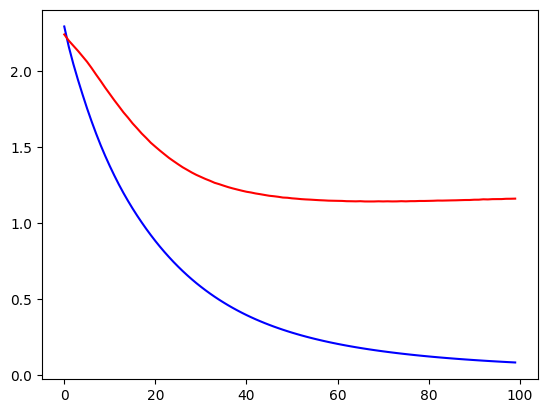

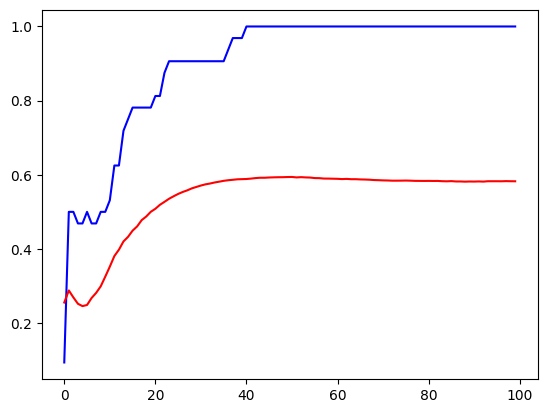

In [16]:
nbatch = 32
nbatches = 1
nepochs = 100
lr = 0.1

trainsize = nbatches*nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
print(len(trainset), len(rest))

model = mlp([28*28, 200, 10])
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-")
plt.plot(range(nepochs), cost_valid, "r-")

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-")
plt.plot(range(nepochs), acc_valid, "r-")

#### Evaluate Train and Validation Performance 

Now run several trainings with the same small model (one hidden layer) and explore for different number of training samples (different number of batches with 32 samples) used, how the train and validation performance evolve (cost and accuracy). Make sure that you train sufficiently long to obtain representative values for cost and accuracy with the given settings. Always use the same validation set (with 10'000 samples).

Create plots with training and validation performance vs number of training batches (one for cost and one for accuracy). Use the performance characteristics obtained at the end.

Discuss the whether there is a sufficient number of training samples for the given problem at hand. Specify a minimum number if applicable. Also consider whether you are in the underfitting regime.

Hint: Specify a list with the number of training batches you would like to perform trainings. Try to be economic with the resources used - try to keep the number of trainings limited.

32 49968
Run with 1 batches
64 49936
Run with 2 batches
160 49840
Run with 5 batches
320 49680
Run with 10 batches
640 49360
Run with 20 batches
1600 48400
Run with 50 batches
3200 46800
Run with 100 batches
6400 43600
Run with 200 batches
16000 34000
Run with 500 batches


Text(0, 0.5, 'Accuracy')

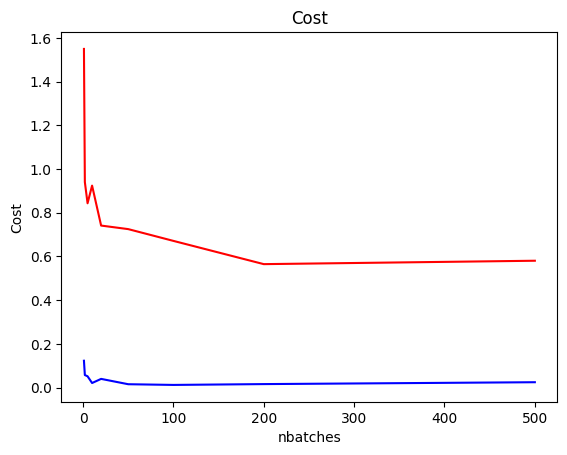

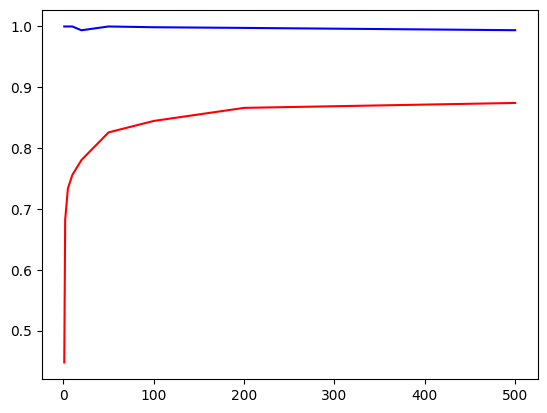

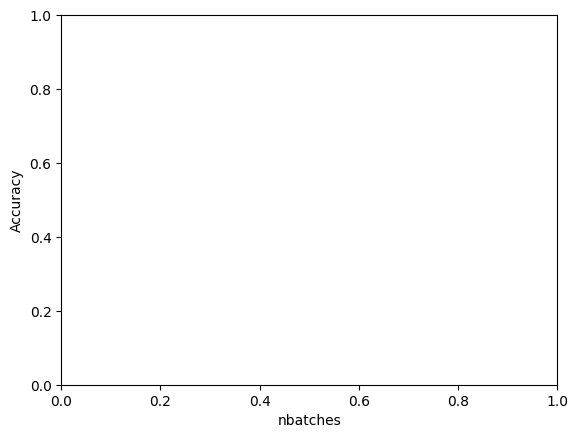

In [21]:
cost_train_list = []
cost_valid_list = []
acc_train_list = []
acc_valid_list = []
nbatches_list = [1,2,5,10,20,50,100,200,500]
for nbatches in nbatches_list:
    nbatch = 32
    nepochs = 100
    lr = 0.1

    trainsize = nbatches*nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
    print(len(trainset), len(rest))

    model = mlp([28*28, 200, 10])
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data, verbose=False)
    cost_train_list.append(cost_train[-1])
    cost_valid_list.append(cost_valid[-1])
    acc_train_list.append(acc_train[-1])
    acc_valid_list.append(acc_valid[-1])

    print(f"Run with {nbatches} batches complete")

plt.figure(1)
plt.plot(nbatches_list, cost_train_list, "b-")
plt.plot(nbatches_list, cost_valid_list, "r-")
plt.title("Cost")
plt.xlabel("nbatches")
plt.ylabel("Cost")

plt.figure(2)
plt.plot(nbatches_list, acc_train_list, "b-")
plt.plot(nbatches_list, acc_valid_list, "r-")
plt.figure("Accuracy")
plt.xlabel("nbatches")
plt.ylabel("Accuracy")

#### Comments: YOUR comments

### Exercise 3: Evaluate Different Model Complexities

Use the same functionality implemented above (create MLP model, train and evaluate model) to evaluate different model complexities: Number of layers and number of units per layer.

Start with the small model used in Exercise 2. Then gradually increase the model complexity. Do this along two dimensions:
* a single hidden layer, but increasing the number of units.
* a fixed number of units per (hidden) layer, but increase the number of layers.
Make sure that you reach the overfitting regime (in either case).

Always use the full training set with 50'000 samples.

Again make sure that you train sufficiently long so that the obtained train and validation performance measures (cost, accuracy) are representative.

Create plots with training and validation performance (cost, accuracy) vs model complexity - one plot with number of units for the single hidden layer case, and one for varying number of layers. 

Again use the performance characteristics obtained at the end. 

Finally, discuss your findings.

In [ ]:
# YOUR CODE HERE #
# several iterations with the code snippets of the form:

nbatch = 64
nepochs = 
lr = 

model = 

cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)

plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-")
plt.plot(range(nepochs), cost_valid, "r-")

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-")
plt.plot(range(nepochs), acc_valid, "r-")



#### Comments: YOUR findings.

### Exercise 4: Add Regularisation

Finally, add regularisation - dropout or L1/L2-regularisation. 

To this end, you need to implement new functionality to instantiate the model.

Start with one of the overfitting cases of Exercise 3 and try to improve the validation performance by adding regularisation. You can use either dropout or L1/L2-regularisation.


In [57]:
# define a method that provides an instance of an MLP incl regularisation which uses as a list of units per layer as input 

def mlp_dropout(units = [28*28, 200, 10], p_in = 0.2, p_hidden=0.5):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers) and dropout 
    regularisation. Dropout rate for all layers the same except for the first (p_in). For the output layer 
    no dropout applied. 
    """

    # YOUR CODE HERE #

    

In [58]:
model = mlp_dropout([28*28,200,10])

from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
           Dropout-4                  [-1, 200]               0
              ReLU-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


#### Playing with different complexities and regularisation

Now play with different complexities and regularisation. 
Start with one of the overfitting cases identified in the previous exercise.
By adding regularisation, you should be able to make it non-overfitting, i.e. generalising better.
Note that for a given complexity, adding regularisation reduces the model capacity. This may need to be compensated by increasing the complexity of the model. 

Use again cost and accuracy for train and validation set to evaluate the results.

Finally, estimate the bias error and the generalisation error. 

In [ ]:

# YOUR CODE HERE #

